In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.preprocessing import text, sequence
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

fake = pd.read_csv('fake_real_news_data/Fake.csv')
true = pd.read_csv('fake_real_news_data/True.csv')

train = pd.read_csv('fake_real_news_data/train.csv')
test = pd.read_csv('fake_real_news_data/test.csv')

Using TensorFlow backend.
C:\Users\Threadripper\anaconda3\envs\tf_dl\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Threadripper\anaconda3\envs\tf_dl\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Threadripper\anaconda3\envs\tf_dl\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Threadripper\anac

In [2]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [3]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
true['category'] = 0
fake['category'] = 1

In [5]:
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [6]:
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [7]:
train.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [8]:
train = train.dropna()

In [9]:
train.isna().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [10]:
train = train.rename(columns={'label': 'category'})
train.head()

,id,title,author,text,category
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [11]:
df = pd.concat([true,fake]) #Merging the 2 datasets

In [12]:
df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [13]:
df.isna().sum()

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [14]:
df.title.count()

44898

In [15]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

[Text(0, 0, 'politicsNews'),
 Text(1, 0, 'worldnews'),
 Text(2, 0, 'News'),
 Text(3, 0, 'politics'),
 Text(4, 0, 'Government News'),
 Text(5, 0, 'left-news'),
 Text(6, 0, 'US_News'),
 Text(7, 0, 'Middle-east')]

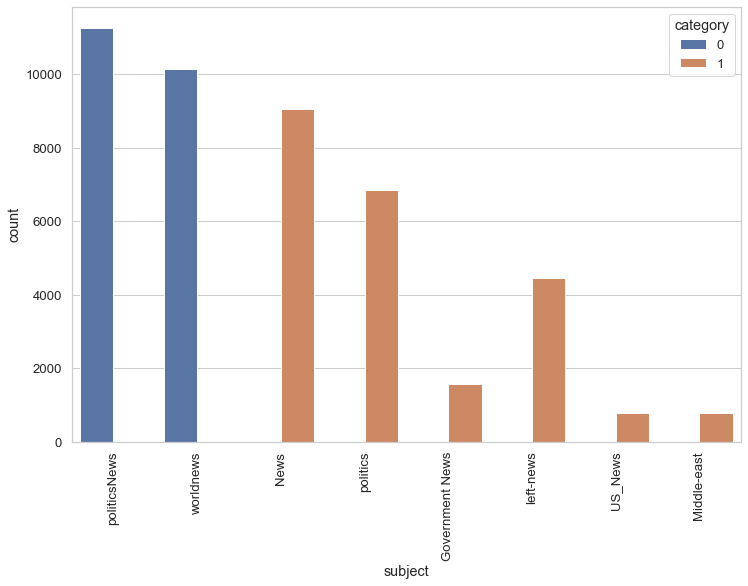

In [16]:
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "subject", hue = "category" , data = df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

In [17]:
df['text'] = df['text'] + " " + df['title']
train['text'] = train['text'] + " " + train['title']

del df['title']
del df['subject']
del df['date']

del train['title']
del train['id']
del train['author']

In [18]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Threadripper\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['text']=df['text'].apply(denoise_text)
train['text']=train['text'].apply(denoise_text)

In [20]:
df.head()

,text,category
0,WASHINGTON (Reuters) head conservative Republi...,0
1,WASHINGTON (Reuters) Transgender people allowe...,0
2,WASHINGTON (Reuters) special counsel investiga...,0
3,WASHINGTON (Reuters) Trump campaign adviser Ge...,0
4,SEATTLE/WASHINGTON (Reuters) President Donald ...,0


In [21]:
train.head()

,text,category
0,House Dem Aide: Didn’t Even See Comey’s Letter...,1
1,Ever get feeling life circles roundabout rathe...,0
2,"Truth Might Get Fired October 29, 2016 tension...",1
3,Videos 15 Civilians Killed Single US Airstrike...,1
4,Print Iranian woman sentenced six years prison...,1


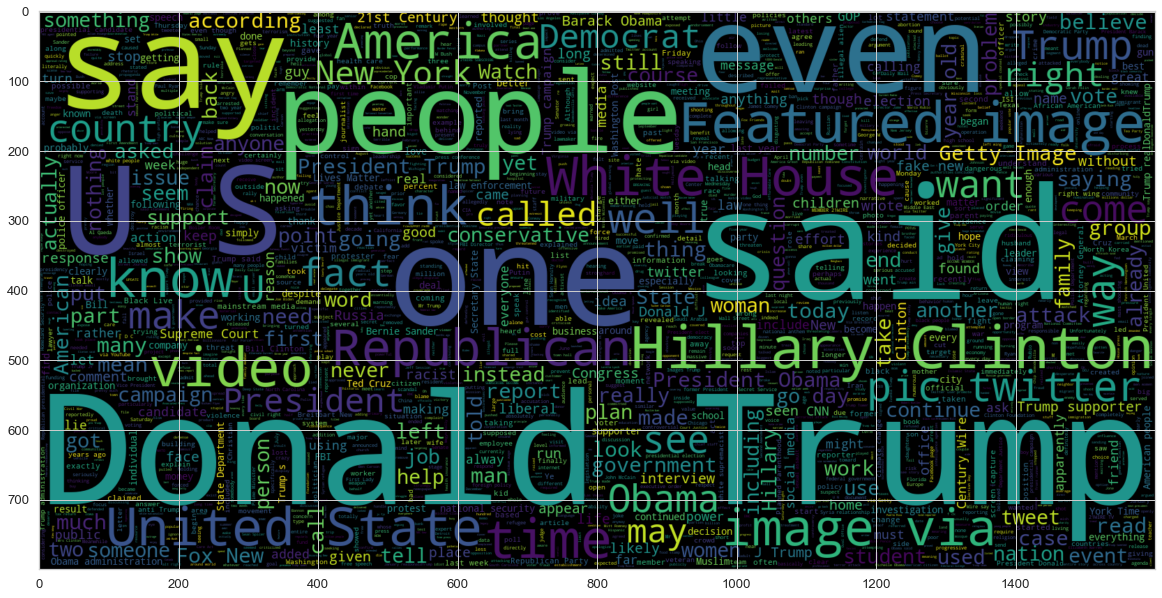

In [22]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

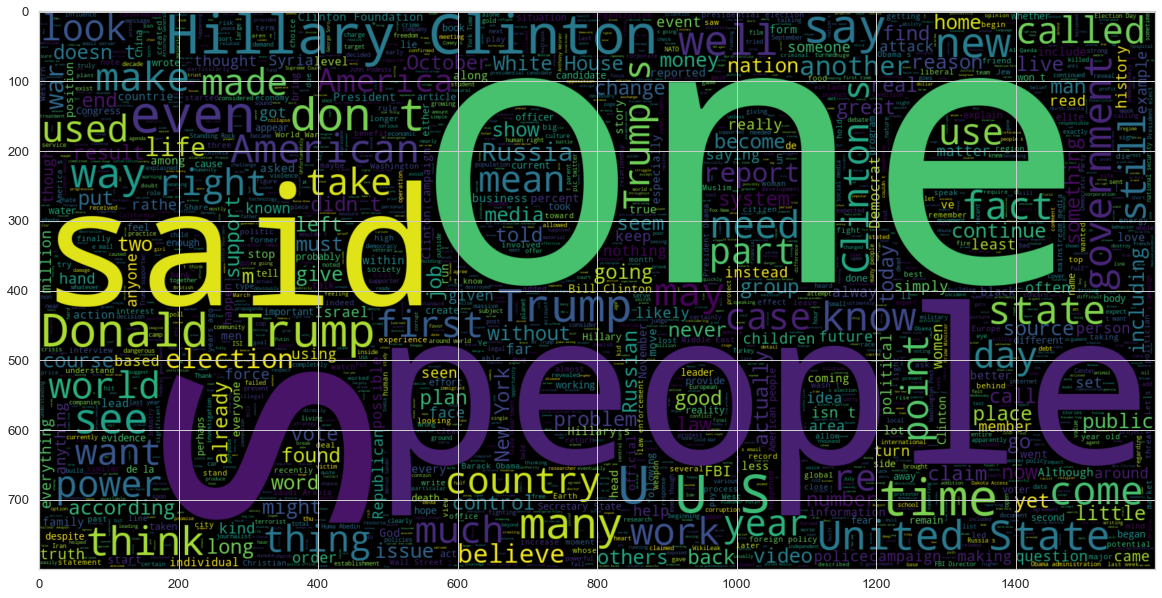

In [23]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(train[train.category == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

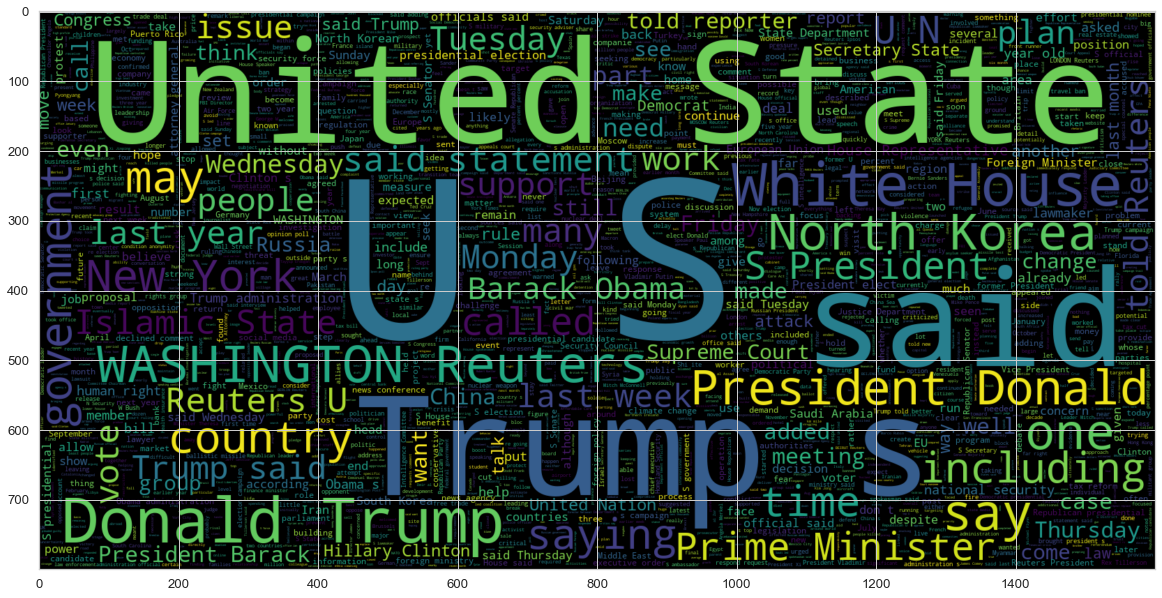

In [24]:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

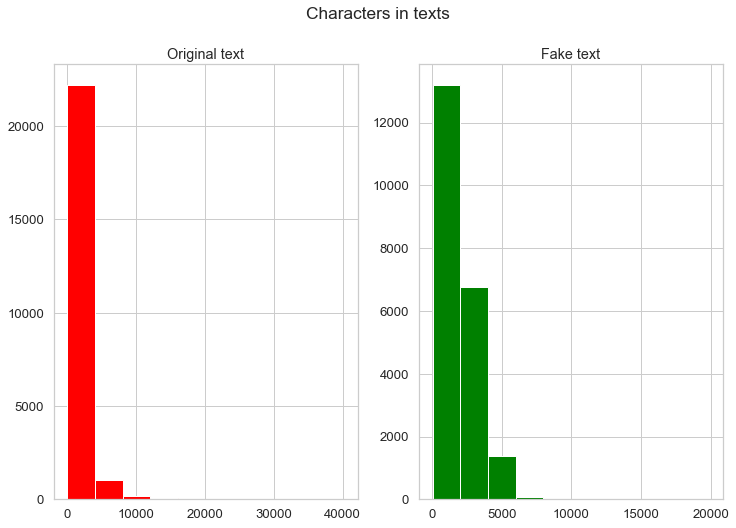

In [25]:
### Character count in texts ###

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']==1]['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=df[df['category']==0]['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Characters in texts')
plt.show()

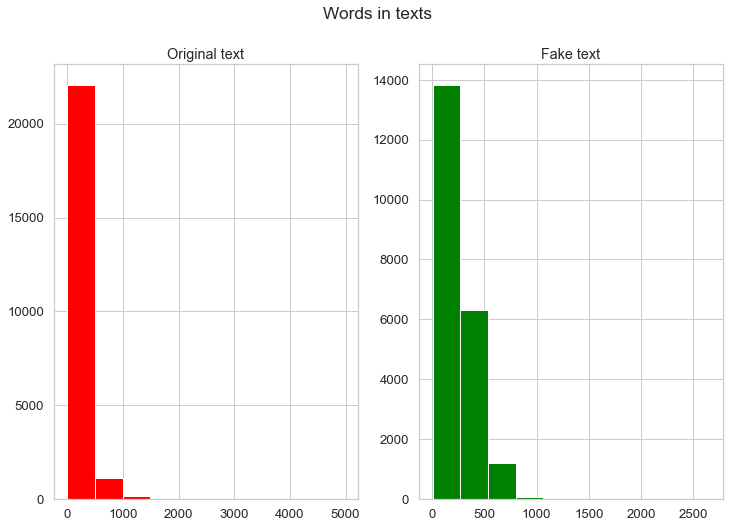

In [26]:
### Word count in texts ###

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['category']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=df[df['category']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Words in texts')
plt.show()

C:\Users\Threadripper\anaconda3\envs\tf_dl\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Threadripper\anaconda3\envs\tf_dl\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Threadripper\anaconda3\envs\tf_dl\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Threadripper\anaconda3\envs\tf_dl\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hist

Text(0.5, 0.98, 'Average word length in each text')

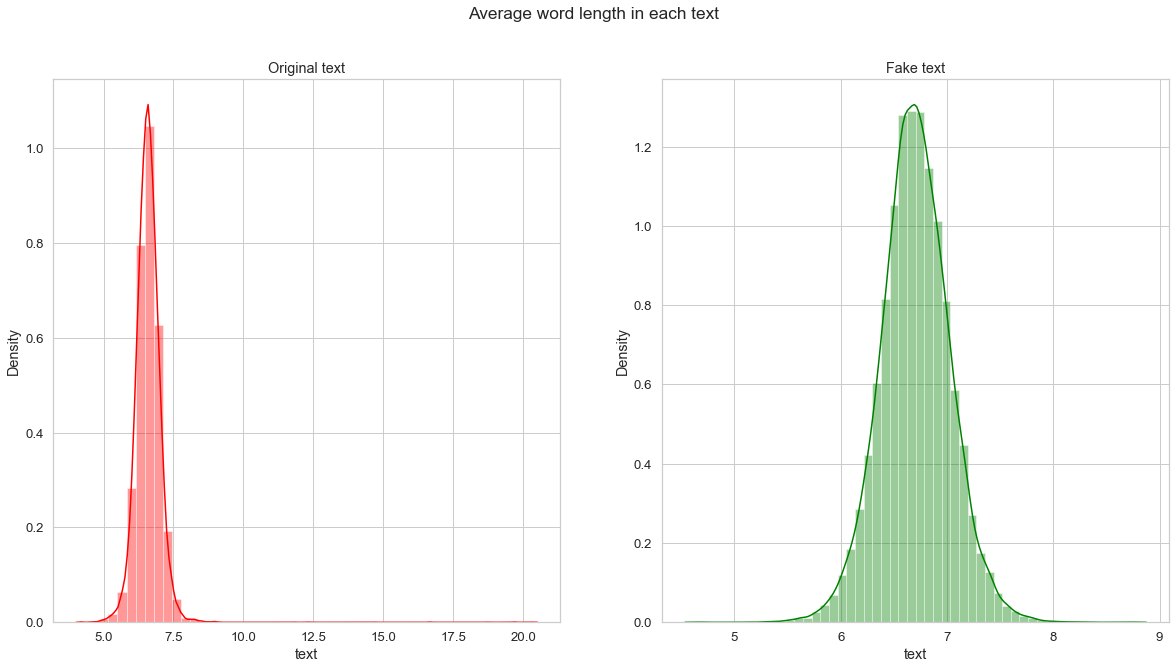

In [27]:
### Average word length in texts ###

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['category']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Original text')
word=df[df['category']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Fake text')
fig.suptitle('Average word length in each text')

In [28]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.text)
corpus[:5]

['WASHINGTON', '(Reuters)', 'head', 'conservative', 'Republican']

In [29]:
corpus_t = get_corpus(train.text)
corpus_t[:5]

['House', 'Dem', 'Aide:', 'Didn’t', 'Even']

In [30]:
### Counting most common words ###

from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'Trump': 111503,
 'said': 93162,
 'would': 54613,
 'U.S.': 50441,
 'President': 33180,
 'people': 33115,
 'also': 30325,
 'one': 29370,
 'Donald': 27795,
 'said.': 26194}

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<AxesSubplot:>

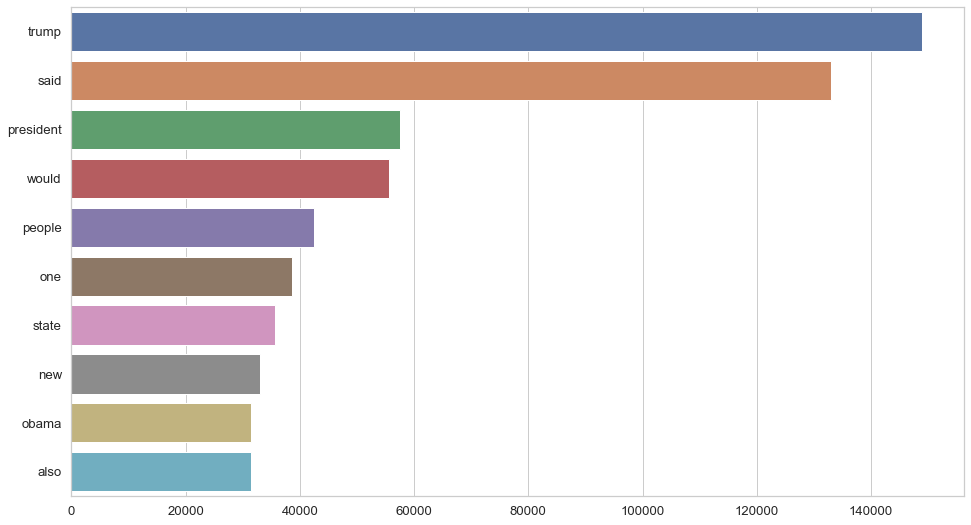

In [32]:
### unigram analysis ###

## I am using 

plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.text,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

<AxesSubplot:>

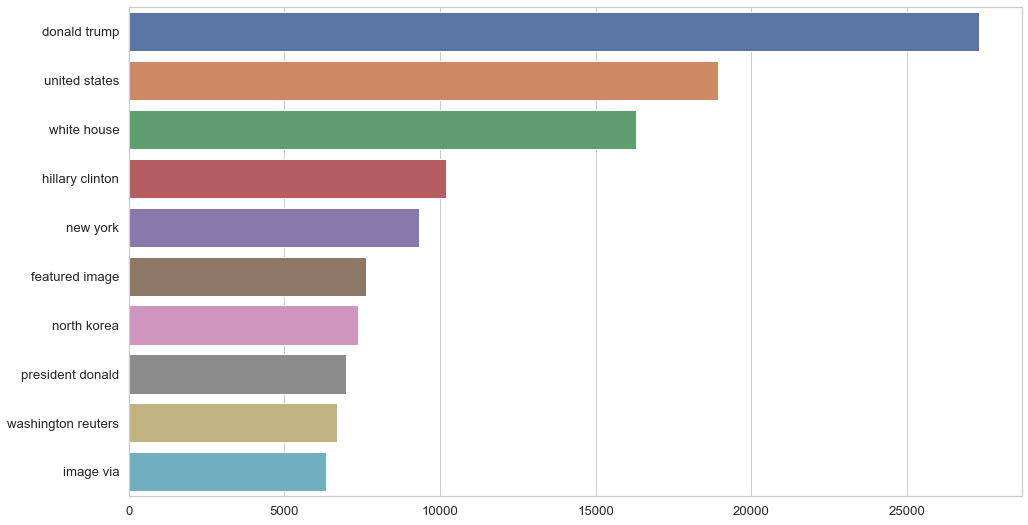

In [33]:
### bigram analysis ###

plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

<AxesSubplot:>

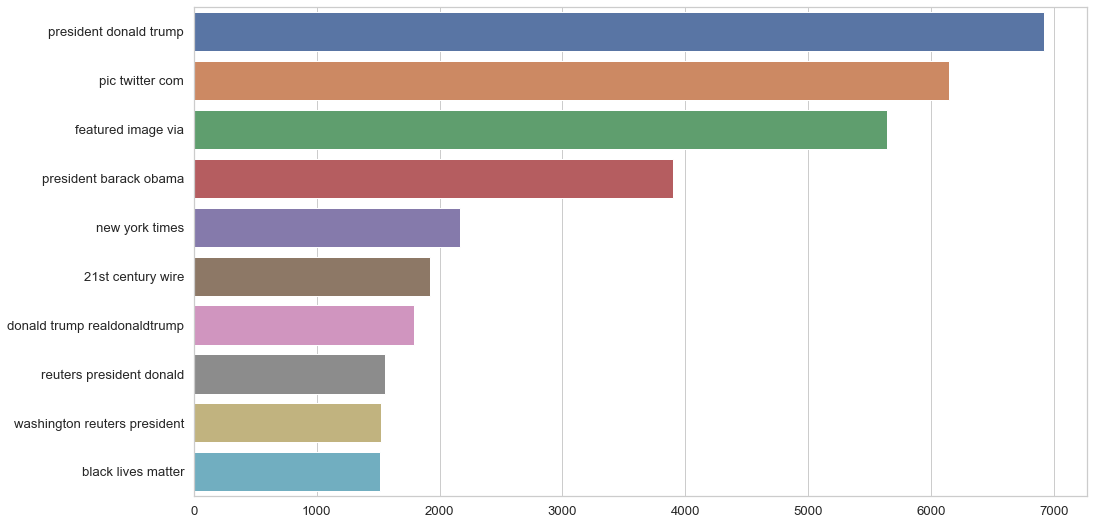

In [34]:
### trigram analysis ####

plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(df.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

In [35]:
### Building model ###

x_train,x_test,y_train,y_test = train_test_split(df.text,df.category,random_state = 0)

In [36]:
x_train_t,x_test_t,y_train_t,y_test_t = train_test_split(train.text, train.category, random_state = 0)

In [37]:
max_features = 10000
maxlen = 300

In [38]:
## model based

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
X_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [39]:
## testing model on another dataset

tokenizer.fit_on_texts(x_train_t)
tokenized_train_t = tokenizer.texts_to_sequences(x_train_t)
X_train_t = sequence.pad_sequences(tokenized_train_t, maxlen=maxlen)

In [40]:
##model based
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [41]:
##testing model
tokenized_test_t = tokenizer.texts_to_sequences(x_test_t)
X_test_t = sequence.pad_sequences(tokenized_test_t, maxlen=maxlen)

In [42]:
# LSTM for sequence classification

# create the model -------- built with fake/true dataset

embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(max_features, embedding_vecor_length, input_length=maxlen))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=64)


# Final evaluation of the model
scores_1 = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores_1[1]*100))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 32)           320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 373,301
Trainable params: 373,301
Non-trainable params: 0
_________________________________________________________________
None

Epoch 1/3
33673/33673 [==============================] - 120s 4ms/step - loss: 0.0901 - accuracy: 0.9690
Epoch 2/3
33673/33673 [==============================] - 119s 4ms/step - loss: 0.0096 - accuracy: 0.9975
Epoch 3/3
33673/33673 [==============================] - 123s 4ms/st

In [43]:
#Checking model on new data set to see if it yields same results
# Final evaluation of the model
scores_2 = model.evaluate(X_test_t, y_test_t, verbose=0)
print("Accuracy: %.2f%%" % (scores_2[1]*100))

Accuracy: 58.66%


In [44]:
#model_2 built with test/train dataset

embedding_vecor_length = 32
model_2 = Sequential()
model_2.add(Embedding(max_features, embedding_vecor_length, input_length=maxlen))
model_2.add(LSTM(100))
model_2.add(Dense(1, activation='sigmoid'))
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model_2.fit(X_train, y_train, epochs=3, batch_size=64)


##Evaluating second model data
scores_3 = model_2.evaluate(X_test_t, y_test_t, verbose=0)
print("Accuracy: %.2f%%" % (scores_3[1]*100))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 32)           320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 373,301
Trainable params: 373,301
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
33673/33673 [==============================] - 117s 3ms/step - loss: 0.1038 - accuracy: 0.9604
Epoch 2/3
33673/33673 [==============================] - 119s 4ms/step - loss: 0.0188 - accuracy: 0.9947
Epoch 3/3
33673/33673 [==============================] - 121s 4ms/step - loss: 0.0034 - accuracy: 0.9992
Accuracy: 51.64%


In [45]:
#Checking model_2 on old data set to see if it yields same results
# Final evaluation of the model
scores_4 = model_2.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores_4[1]*100))

Accuracy: 51.28%


In [46]:
###########################################################################################################################

#### Results analysis

The LSTM model above rendered some interesting results 

### I am going add another layer to the model to see if my results improve.
I am going to combine a CNN and LSTM. The prior data showed that there was some overfitting going on. This could be possibly due to the dataset size, the power of the model used, or having too many layers in the model. 

In [47]:
### CNN + LSTM ###
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(max_features, embedding_vecor_length, input_length=maxlen))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=64)


# Final evaluation of the model
scores_lstm = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores_lstm[1]*100))


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 32)           320000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 300, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 150, 32)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 376,405
Trainable params: 376,405
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
33673/33673 [==============================] - 71s 2ms/step - loss: 0.0854 - accuracy: 0.9664
Epoc

In [48]:
#Checking model on new data set to see if it yields same results
# Final evaluation of the model
scores_lstm_2 = model.evaluate(X_test_t, y_test_t, verbose=0)
print("Accuracy: %.2f%%" % (scores_lstm_2[1]*100))

Accuracy: 50.07%


In [49]:
### CNN + LSTM ###
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import ModelCheckpoint

# create the model
embedding_vecor_length = 32
model_2 = Sequential()
model_2.add(Embedding(max_features, embedding_vecor_length, input_length=maxlen))
model_2.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_2.add(MaxPooling1D(pool_size=2))
model_2.add(LSTM(100))
model_2.add(Dense(1, activation='sigmoid'))
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_2.summary())

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model_2.fit(X_train_t, y_train_t, epochs=3, batch_size=64, callbacks=callbacks_list, verbose = 0)


# Final evaluation of the model
scores_lstm_2 = model_2.evaluate(X_test_t, y_test_t, verbose=0)
print("Accuracy: %.2f%%" % (scores_lstm_2[1]*100))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 300, 32)           320000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 300, 32)           3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 150, 32)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 376,405
Trainable params: 376,405
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Threadripper\anaconda3\envs\tf_dl\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_accuracy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Accuracy: 97.75%


In [ ]:
### The above result is interesting. yielding some different results this time.

In [50]:
# Final evaluation of the model

scores_lstm_3 = model_2.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores_lstm_3[1]*100))

Accuracy: 67.08%


Refer to the following article for guide with GloVe method.

Reference article: https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010